## Importing Libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime
import itertools

import sklearn
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox 

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

import warnings
from math import sqrt
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
import pmdarima as pm

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from pandas.tseries.offsets import DateOffset
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages


In [2]:
df = pd.read_csv("CO2_dataset.csv")
df.head()

,Year,CO2
0,1800.0,0.00568
1,1801.0,0.00561
2,1802.0,0.00555
3,1803.0,0.00548
4,1804.0,0.00542


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    215 non-null    float64
 1   CO2     215 non-null    float64
dtypes: float64(2)
memory usage: 15.7 KB


In [4]:
dateparse = lambda x: pd.to_datetime(x, format='%Y', errors = 'coerce')
df = pd.read_csv("CO2_dataset.csv", parse_dates=['Year'], index_col='Year', date_parser=dateparse) 
df.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


<AxesSubplot:xlabel='CO2'>

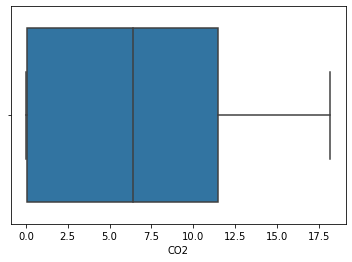

In [5]:
sns.boxplot(df['CO2'])

<AxesSubplot:xlabel='Year'>

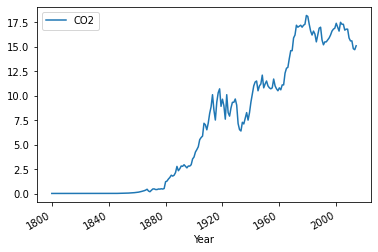

In [6]:
df.plot()

## Transforming data to normal distribution

In [7]:
def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    plt.show()
    

### Log Transformation

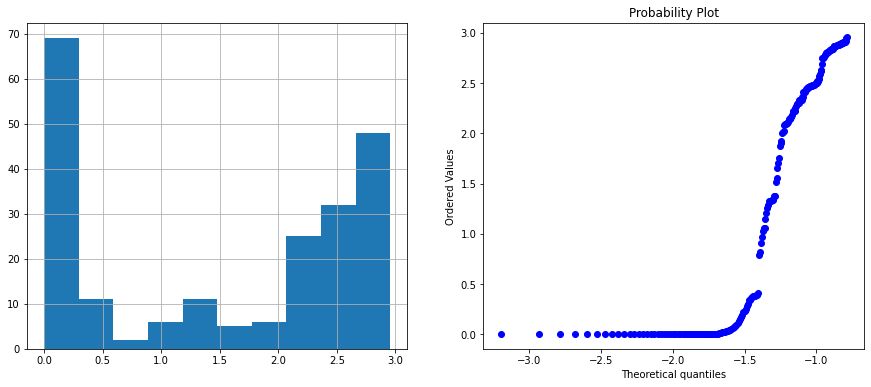

In [8]:
df['Log_co2']=np.log(df['CO2']+1)
diagnostic_plots(df,'Log_co2')

### Reciprocal Transformation

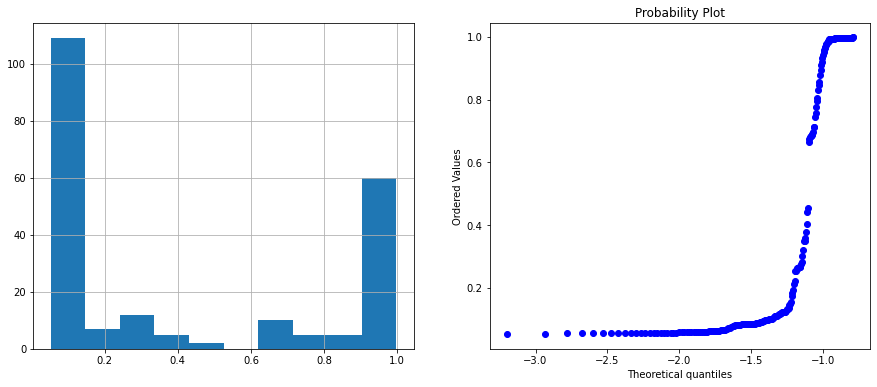

In [9]:
df['Rec_co2']=1/(df['CO2']+1)
diagnostic_plots(df,'Rec_co2')

### Square-Root Transformation

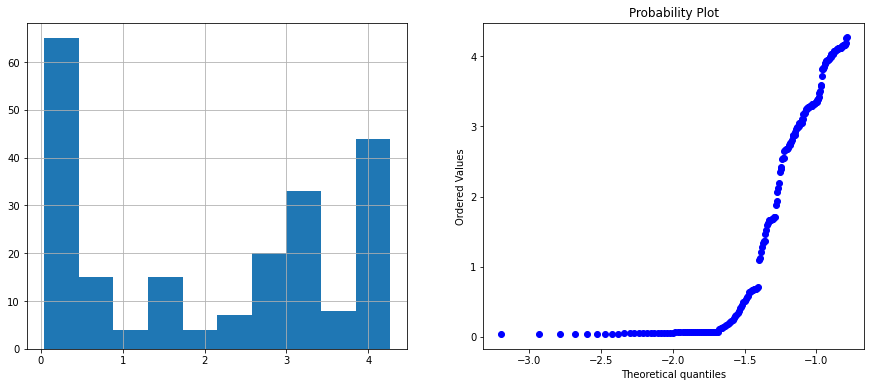

In [10]:
df['sqr_co2']=df['CO2']**(1/2)
diagnostic_plots(df,'sqr_co2')

### Exponential Transformation

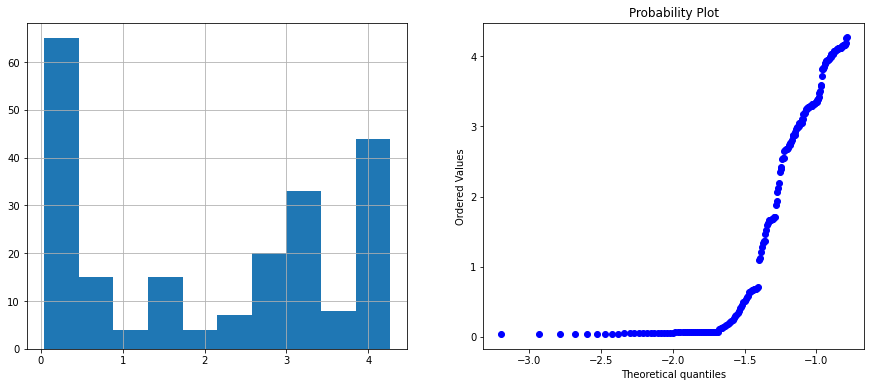

In [11]:
df['Exp_co2']=df['CO2']**(1/5)
diagnostic_plots(df,'sqr_co2')

### Box-cox Transformation

Optimal lambda:  8.472135811722177


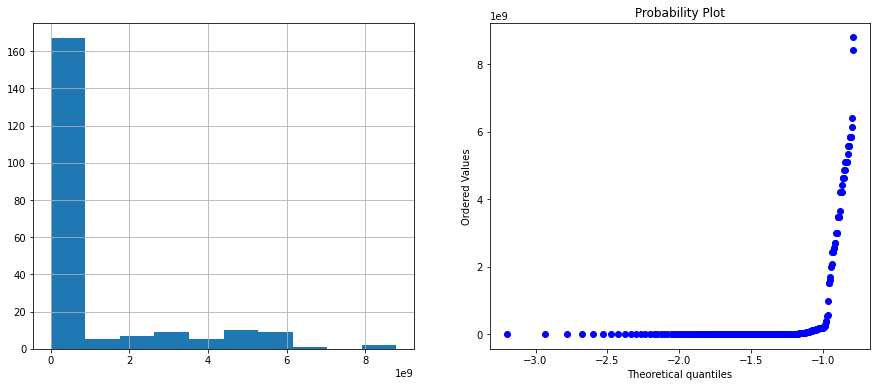

In [12]:
df['co2_boxcox'], param = stats.boxcox(df.CO2+1) # you can vary the exponent as needed

print('Optimal lambda: ', param)

diagnostic_plots(df, 'co2_boxcox')

array([[-1.41804651, -1.48126815,  1.22566669, -1.41804651, -1.41804651,
        -1.27455723],
       [-1.41947121, -1.48261311,  1.22571353, -1.41947121, -1.41947121,
        -1.27536049],
       [-1.42070347, -1.48377472,  1.22575368, -1.42070347, -1.42070347,
        -1.27605665],
       ...,
       [        nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan]])

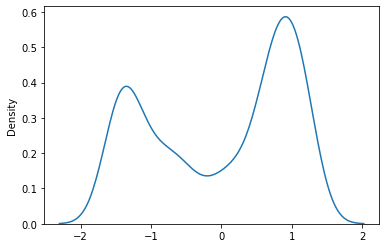

In [13]:

pt = PowerTransformer(method='box-cox')
data = pt.fit_transform(df)
sns.distplot(data, hist=False, kde=True)
data

<AxesSubplot:ylabel='Density'>

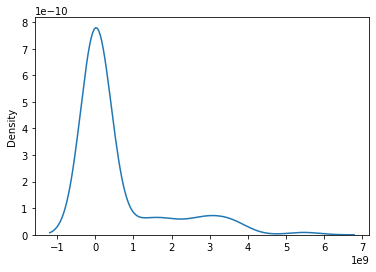

In [14]:

#perform Box-Cox transformation on original data
transformed_data, best_lambda = boxcox(df.CO2) 

#plot the distribution of the transformed data values
sns.distplot(transformed_data, hist=False, kde=True)

In [15]:
df.dtypes

CO2           float64
Log_co2       float64
Rec_co2       float64
sqr_co2       float64
Exp_co2       float64
co2_boxcox    float64
dtype: object

<AxesSubplot:xlabel='Year'>

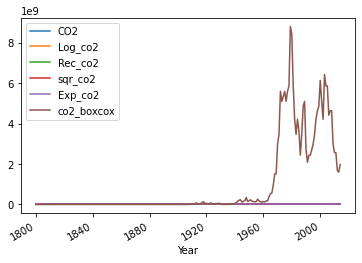

In [16]:
df.plot()

<AxesSubplot:xlabel='Year'>

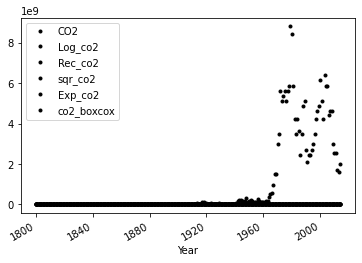

In [17]:
df.plot(style = 'k.')

In [18]:
df.describe()

,CO2,Log_co2,Rec_co2,sqr_co2,Exp_co2,co2_boxcox
count,215.000000,215.000000,215.000000,215.000000,215.000000,2.150000e+02
mean,6.741970,1.490057,0.420248,2.055194,1.159068,9.426668e+08
std,6.522437,1.180641,0.404516,1.590570,0.563587,1.878681e+09
min,0.001750,0.001748,0.052083,0.041833,0.280936,1.761485e-03
25%,0.041050,0.040224,0.080000,0.202429,0.527736,4.799339e-02
50%,6.390000,2.000128,0.135318,2.527845,1.449106,2.699484e+06
75%,11.500000,2.525729,0.960579,3.391165,1.629820,2.318343e+08
max,18.200000,2.954910,0.998253,4.266146,1.786546,8.796489e+09


array([[<AxesSubplot:title={'center':'CO2'}>,
        <AxesSubplot:title={'center':'Log_co2'}>],
       [<AxesSubplot:title={'center':'Rec_co2'}>,
        <AxesSubplot:title={'center':'sqr_co2'}>],
       [<AxesSubplot:title={'center':'Exp_co2'}>,
        <AxesSubplot:title={'center':'co2_boxcox'}>]], dtype=object)

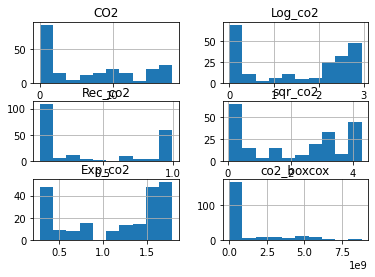

In [19]:
df.hist()

Since we didnot get any conclusive evidence of being normal distribution. We have decided to move on without transforming it to normal distribution.

#### Dropping all transformed values from dataset

In [20]:
df = df.drop(['co2_boxcox', 'Log_co2','Rec_co2','sqr_co2','Exp_co2'], axis = 1)

In [21]:
df.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [22]:
df.dtypes

CO2    float64
dtype: object

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 999 entries, 1800-01-01 to NaT
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO2     215 non-null    float64
dtypes: float64(1)
memory usage: 15.6 KB


<AxesSubplot:xlabel='Year'>

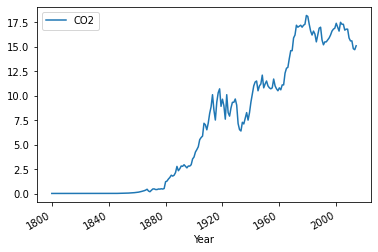

In [24]:
df.plot()

<AxesSubplot:xlabel='Year'>

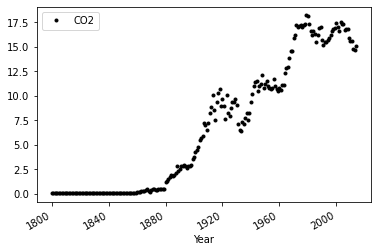

In [25]:
df.plot(style = 'k.')

Preliminary analysis of above plot says that there is presence of clear Level and Trend but we can't say about Seasonality right now.

In [26]:
df.describe()

,CO2
count,215.000000
mean,6.741970
std,6.522437
min,0.001750
25%,0.041050
50%,6.390000
75%,11.500000
max,18.200000


array([[<AxesSubplot:title={'center':'CO2'}>]], dtype=object)

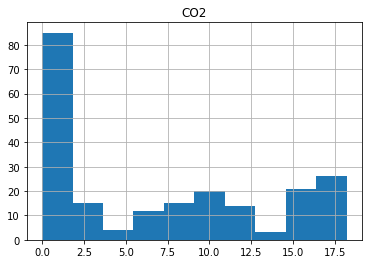

In [27]:
df.hist()

# A) MODEL BUILDING ON STATIONARY DATA

## Test Stationary

Naive test for stationary by checking constant mean and variance

In [28]:
X = df.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=nan, mean2=nan
variance1=nan, variance2=nan


Since mean and variance changes drastically it is evident that out data is not stationary. Let's confirm it using ADFuller test.

### Testing Stationary using ADFuller test

In [29]:
def TestStationaryPlot(df):
    rol_mean = df.rolling(window = 20, center = False).mean()
    rol_std = df.rolling(window = 20, center = False).std()
    
    plt.plot(df, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.xlabel('Time in Years', fontsize = 10)
    plt.ylabel('Total Emissions', fontsize = 10)
    plt.legend(loc='best', fontsize = 10)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 10)
    plt.show(block= True)

In [30]:
# null Hypothesis : Data is stationary
#alternate hypothesis : Data is not stationary
def TestStationaryAdfuller(df, cutoff = 0.01):
    df_test = adfuller(df, autolag = 'AIC')
    df_test_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in df_test[4].items():
        df_test_output['Critical Value (%s)'%key] = value
    print(df_test_output)
    
    if df_test[1] <= cutoff:
        print("Failed to reject null hypothesis. Data is stationary")
    else:
        print("Failed to accept null hypothesis. Data is non-stationary ")
        

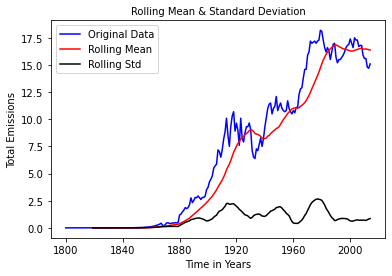

In [31]:
TestStationaryPlot(df)

## Transforming data to Stationary

Transforming data to stationary using three following methods:
- Moving Average
- Differencing
- Decomposing

### 1. Moving Average

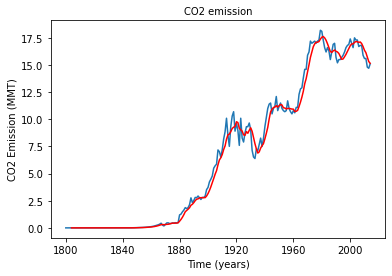

In [32]:
moving_avg = df.rolling(5).mean()
plt.plot(df)
plt.plot(moving_avg, color='red')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Time (years)', fontsize = 10)
plt.ylabel('CO2 Emission (MMT)', fontsize = 10)
plt.title('CO2 emission', fontsize = 10)
plt.show()

In [33]:
moving_avg_diff = df - moving_avg
moving_avg_diff.head(13)

,CO2
Year,
1800-01-01,NaN
1801-01-01,NaN
1802-01-01,NaN
1803-01-01,NaN
1804-01-01,-0.000128
1805-01-01,-0.000124
1806-01-01,-0.000130
1807-01-01,-0.000126
1808-01-01,-0.000124


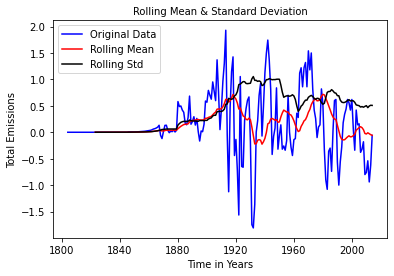

In [34]:
moving_avg_diff.dropna(inplace=True)
TestStationaryPlot(moving_avg_diff)

In [35]:
TestStationaryAdfuller(moving_avg_diff)

Test Statistic                  -3.944115
p-value                          0.001733
#Lags Used                       4.000000
Number of Observations Used    206.000000
Critical Value (1%)             -3.462499
Critical Value (5%)             -2.875675
Critical Value (10%)            -2.574304
dtype: float64
Failed to reject null hypothesis. Data is stationary


The rolling mean values appear to be varying slightly. The Test Statistic is smaller than the 10% 5%, and 1% of critical values. So, we can say with 99% confidence level that the dataset is a stationary series.

### 2. Eliminating trend and seasonality: Differencing

One of the most common method of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the original observation at a particular instant with that at the previous instant. This mostly works well to improve stationarity. First order differencing can be done as follows:

#### 2(A) : First order differencing

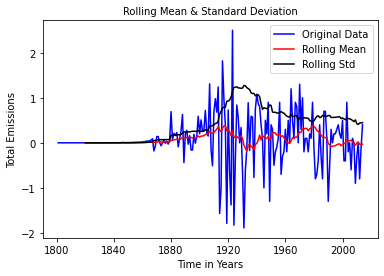

In [36]:
df_first_difference = df - df.shift(1)  
TestStationaryPlot(df_first_difference.dropna(inplace=False))

In [37]:
TestStationaryAdfuller(df_first_difference.dropna(inplace=False))

Test Statistic                  -3.780005
p-value                          0.003119
#Lags Used                      15.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64
Failed to reject null hypothesis. Data is stationary


The first difference improves the stationarity of the series significantly. Let us use also the ***seasonal first order difference*** to remove the seasonality of the data and see how that impacts stationarity of the data.

#### 2(B) : Seasonal First order differencing

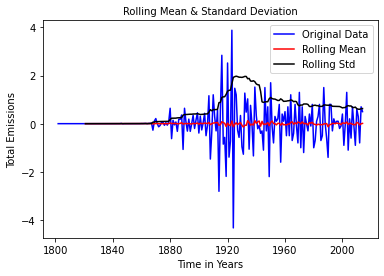

In [38]:
df_seasonal_first_difference = df_first_difference - df_first_difference.shift(1)  
TestStationaryPlot(df_seasonal_first_difference.dropna(inplace=False))

In [39]:
TestStationaryAdfuller(df_seasonal_first_difference.dropna(inplace=False))

Test Statistic                  -5.536081
p-value                          0.000002
#Lags Used                      14.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64
Failed to reject null hypothesis. Data is stationary


We are considering this seasonal first difference for further analysis because it looks more stationary

## Plot the ACF and PACF charts and find the optimal parameters

* **Autocorrelation Function (ACF)**: It is a measure of the correlation between the the time series (ts) with a lagged version of itself.
* **Partial Autocorrelation Function (PACF)**: This measures the correlation between the ts with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons.

In the next step we will be determing the tuning parameters (p and q) of the model by looking at the autocorrelation and partial autocorrelation plots.  The plot below provides a brief guide on how to read the autocorrelation and partial autocorrelation graphs inorder to select the parameters. 

### ACF & PACF plot for seasonal first order difference

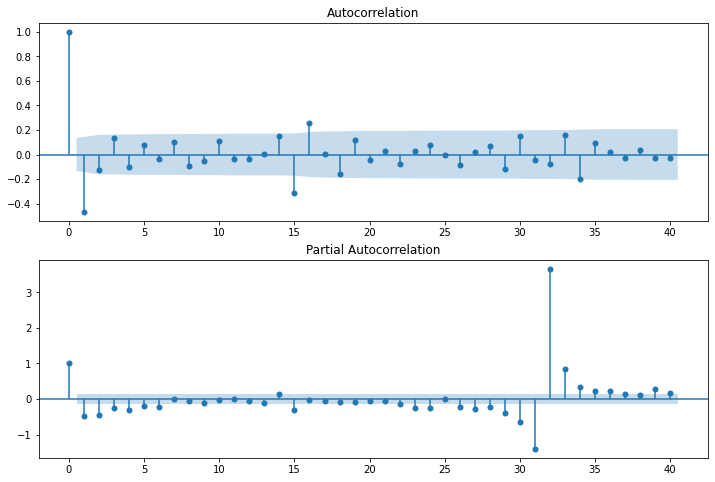

In [40]:
#ACF and PACF plots:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_seasonal_first_difference.dropna(inplace=False), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_seasonal_first_difference.dropna(inplace=False), lags=40, ax=ax2)

We will find optimal parameters (p,d,q) using grid search later

## Data Partitioning

- **Training Data** = Fit the model only to training period
- **Validating Data** = Assess the model performance on validation
- Deploy model by training on whole dataset
- No random partition That’s because the order sequence of the time series should be intact in order to use it for forecasting.

In [41]:
#using seasonal first order difference
df_seasonal_first_difference.head()

,CO2
Year,
1800-01-01,NaN
1801-01-01,NaN
1802-01-01,0.00001
1803-01-01,-0.00001
1804-01-01,0.00001


In [42]:
X = df_seasonal_first_difference.dropna(inplace=False)

In [43]:
X.head()

,CO2
Year,
1802-01-01,1.000000e-05
1803-01-01,-1.000000e-05
1804-01-01,1.000000e-05
1805-01-01,-8.673617e-19
1806-01-01,-1.000000e-05


In [44]:
# Create Training and Test
train = X.iloc[:-20]
test = X.iloc[-20:]

In [45]:
print(train.shape,test.shape)

(193, 1) (20, 1)


In [46]:
train.head()

,CO2
Year,
1802-01-01,1.000000e-05
1803-01-01,-1.000000e-05
1804-01-01,1.000000e-05
1805-01-01,-8.673617e-19
1806-01-01,-1.000000e-05


In [47]:
test.head()

,CO2
Year,
1995-01-01,1.776357e-15
1996-01-01,1.000000e-01
1997-01-01,1.000000e-01
1998-01-01,-2.000000e-01
1999-01-01,-1.000000e-01


### Hyper-parameter Tuning : Finding out optimal (p,d,q)

In [48]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [49]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [50]:
# evaluate parameters
p_values = [0, 1, 2, 3, 4, 5]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(train.values, test.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.613
ARIMA(0, 0, 1) RMSE=0.467
ARIMA(0, 0, 2) RMSE=0.471
ARIMA(0, 1, 0) RMSE=1.037
ARIMA(0, 1, 1) RMSE=0.613
ARIMA(0, 1, 2) RMSE=0.450
ARIMA(0, 2, 0) RMSE=1.853
ARIMA(0, 2, 1) RMSE=1.039
ARIMA(0, 2, 2) RMSE=0.678
ARIMA(1, 0, 0) RMSE=0.546
ARIMA(1, 0, 1) RMSE=0.470
ARIMA(1, 0, 2) RMSE=0.464
ARIMA(1, 1, 0) RMSE=0.838
ARIMA(1, 1, 1) RMSE=0.546
ARIMA(1, 1, 2) RMSE=0.451
ARIMA(1, 2, 0) RMSE=1.374
ARIMA(1, 2, 1) RMSE=0.840
ARIMA(1, 2, 2) RMSE=0.613
ARIMA(2, 0, 0) RMSE=0.443
ARIMA(2, 0, 1) RMSE=0.476
ARIMA(2, 0, 2) RMSE=0.462
ARIMA(2, 1, 0) RMSE=0.634
ARIMA(2, 1, 1) RMSE=0.443
ARIMA(2, 1, 2) RMSE=0.455
ARIMA(2, 2, 0) RMSE=0.999
ARIMA(2, 2, 1) RMSE=0.636
ARIMA(2, 2, 2) RMSE=0.446
ARIMA(3, 0, 0) RMSE=0.433
ARIMA(3, 0, 1) RMSE=0.465
ARIMA(3, 0, 2) RMSE=0.467
ARIMA(3, 1, 0) RMSE=0.573
ARIMA(3, 1, 1) RMSE=0.434
ARIMA(3, 1, 2) RMSE=0.444
ARIMA(3, 2, 0) RMSE=0.863
ARIMA(3, 2, 1) RMSE=0.575
ARIMA(3, 2, 2) RMSE=0.439
ARIMA(4, 0, 0) RMSE=0.457
ARIMA(4, 0, 1) RMSE=0.466
ARIMA(4, 0, 

## ARIMA model

In [80]:
#3,0,0
model_arima = ARIMA(train['CO2'],order = (3,0,0))
model_arima = model_arima.fit()
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  195
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -166.152
Date:                Thu, 23 Dec 2021   AIC                            342.305
Time:                        23:50:27   BIC                            358.670
Sample:                    01-01-1800   HQIC                           348.931
                         - 01-01-1994                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4549      6.804      1.096      0.273      -5.880      20.790
ar.L1          0.9754      0.044     22.000      0.000       0.889       1.062
ar.L2         -0.0662      0.063     -1.056      0.291      -0.189       0.057
ar.L3          0.0882      0.051      1.722      0.085      -0.012       0.189
sigma2         0.3134      0.023     13.905      0.000       0.269       0.358
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                89.73
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):              84.99   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

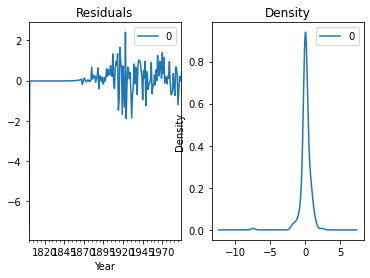

In [83]:
# Plot residual errors
residuals = pd.DataFrame(model_arima.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [84]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})


In [85]:
stationary_arima_acc = forecast_accuracy(pred_arima.values, test.values)
stationary_arima_acc

{'mape': nan, 'me': nan, 'mae': nan, 'mpe': nan, 'rmse': nan}

## Auto Regressor (AR) model

In [86]:
model_ar = AutoReg(train,lags = 6).fit()
print(model_ar.summary())

                            AutoReg Model Results                             
Dep. Variable:                    CO2   No. Observations:                  195
Model:                     AutoReg(6)   Log Likelihood                -156.657
Method:               Conditional MLE   S.D. of innovations              0.554
Date:                Thu, 23 Dec 2021   AIC                             -1.095
Time:                        23:50:41   BIC                             -0.958
Sample:                    01-01-1806   HQIC                            -1.040
                         - 01-01-1994                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0825      0.057      1.455      0.146      -0.029       0.194
CO2.L1         0.9624      0.072     13.329      0.000       0.821       1.104
CO2.L2        -0.0852      0.100     -0.852      0.3

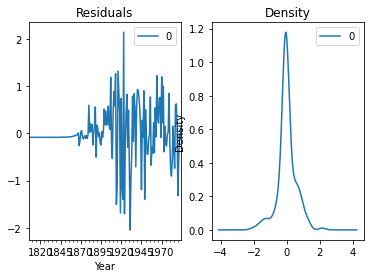

In [88]:
# Plot residual errors
residuals = pd.DataFrame(model_ar.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [89]:
stationary_ar_acc = forecast_accuracy(pred_ar.values, test.values)
stationary_ar_acc

{'mape': nan, 'me': nan, 'mae': nan, 'mpe': nan, 'rmse': nan}

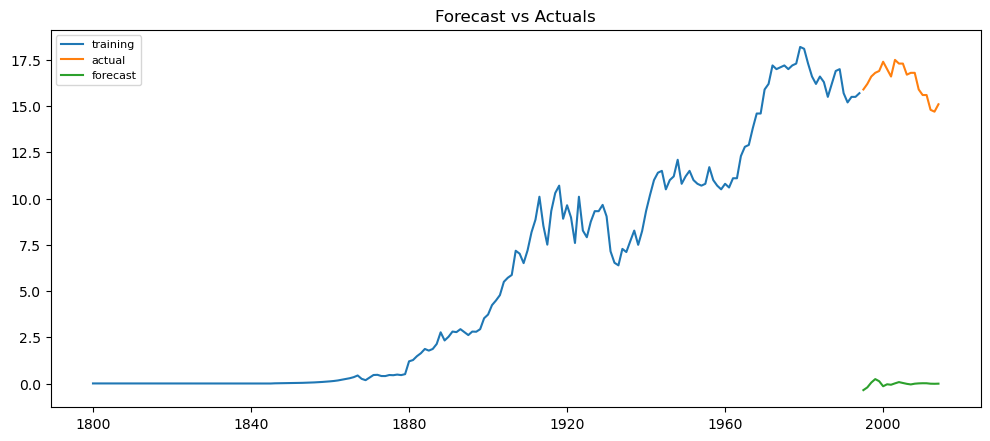

In [90]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ar, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Moving Average (MA) model

In [91]:
# only use q or MA parameter
#MA(3)
model_ma = ARIMA(train['CO2'],order = (0,1,3))
model_ma = model_ma.fit()
model_ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  195
Model:                 ARIMA(0, 1, 3)   Log Likelihood                -161.848
Date:                Thu, 23 Dec 2021   AIC                            331.696
Time:                        23:50:49   BIC                            344.768
Sample:                    01-01-1800   HQIC                           336.989
                         - 01-01-1994                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0150      0.046     -0.324      0.746      -0.106       0.076
ma.L2         -0.1201      0.050     -2.407      0.016      -0.218      -0.022
ma.L3          0.0990      0.047      2.089      0.037       0.006       0.192
sigma2         0.3105      0.023     13.680      0.000       0.266       0.355
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                85.65
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):            3628.50   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

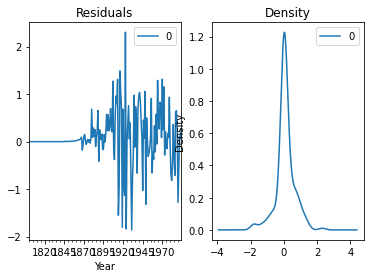

In [93]:
# Plot residual errors
residuals = pd.DataFrame(model_ma.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [94]:
stationary_ma_acc = forecast_accuracy(pred_ma.values, test.values)
stationary_ma_acc

{'mape': nan, 'me': nan, 'mae': nan, 'mpe': nan, 'rmse': nan}

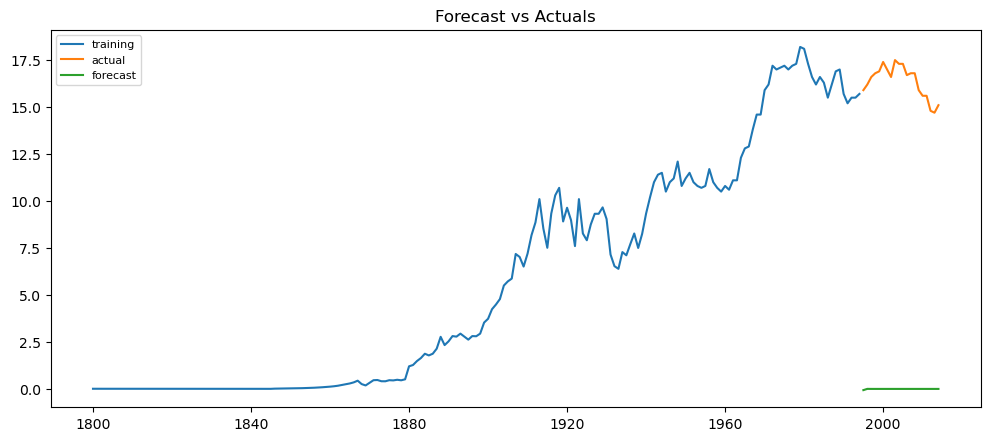

In [95]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ma, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Auto ARIMA model

In [96]:
model = pm.auto_arima(train['CO2'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=327.249, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=328.890, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=328.788, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=329.304, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=330.241, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.305 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  195
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -161.625
Date:                Thu, 23 Dec 2021   AIC                            327.249
Time:                        23:50:58   BIC                            333.785
Sample:                             0   HQIC                           329.896
                                - 195                                         
Co

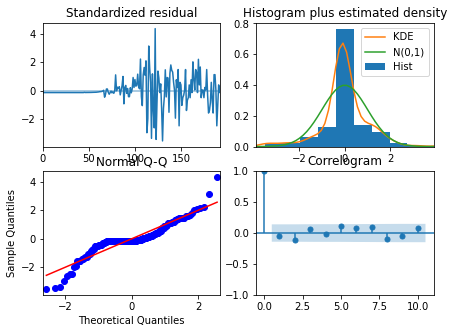

In [97]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [98]:
pred = model.predict(start=start,end=end)
print(pred)

[15.78089841 15.86179682 15.94269523 16.02359364 16.10449205 16.18539046
 16.26628887 16.34718728 16.42808569 16.50898411]


In [99]:
stationary_aa_acc = forecast_accuracy(pred, test.values)
stationary_aa_acc

{'mape': nan, 'me': nan, 'mae': nan, 'mpe': nan, 'rmse': nan}

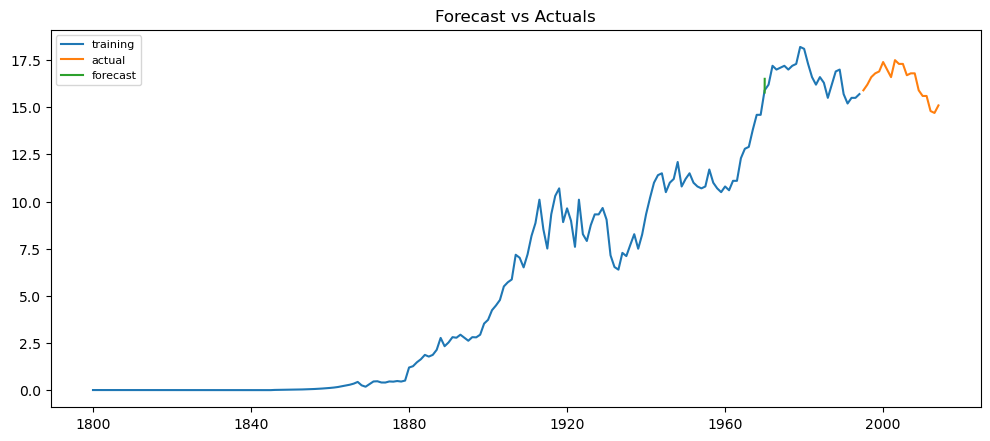

In [100]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [101]:
data = {"MODEL":pd.Series(["ARIMA","Auto Regressor","Moving Average","Auto ARIMA"]),"RMSE_Values":pd.Series([stationary_arima_acc["rmse"],stationary_ar_acc["rmse"],
stationary_ma_acc["rmse"],stationary_aa_acc["rmse"]]),"MAPE_values":pd.Series([stationary_arima_acc["mape"],stationary_ar_acc["mape"],stationary_ma_acc["mape"],stationary_aa_acc["mape"]]),
"ME_values":pd.Series([stationary_arima_acc["me"],stationary_ar_acc["me"],stationary_ma_acc["me"],stationary_aa_acc["me"]]),
"MAE_values":pd.Series([stationary_arima_acc["mae"],stationary_ar_acc["mae"],stationary_ma_acc["mae"],stationary_aa_acc["mae"]]),
        "MPE_values":pd.Series([stationary_arima_acc["mpe"],stationary_ar_acc["mpe"],stationary_ma_acc["mpe"],stationary_aa_acc["mpe"]])}

table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values,MAPE_values,ME_values,MAE_values,MPE_values
0,ARIMA,NaN,NaN,NaN,NaN,NaN
1,Auto Regressor,NaN,NaN,NaN,NaN,NaN
2,Moving Average,NaN,NaN,NaN,NaN,NaN
3,Auto ARIMA,NaN,NaN,NaN,NaN,NaN


# B) MODEL BUILDING ON NON-STATIONARY DATA / ORIGINAL DATA

In [102]:
df.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


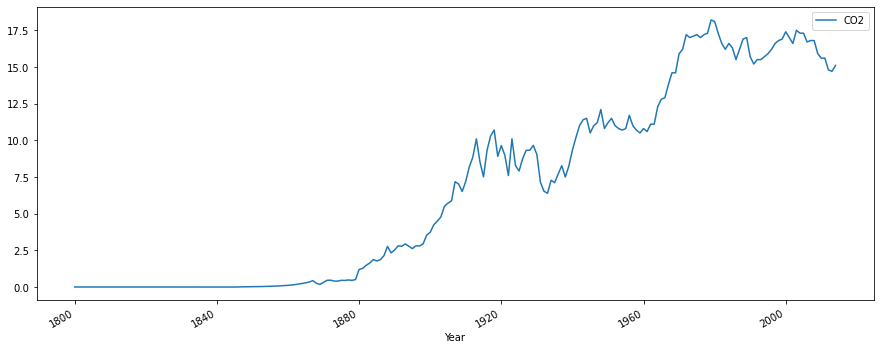

In [103]:
df.plot(figsize=(15, 6))
plt.show()

## Data Partitioning

In [104]:
train = df[:195]
test = df[195:]
print(train.shape,test.shape)

(195, 1) (804, 1)


In [105]:
train.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [106]:
test.head()

,CO2
Year,
1995-01-01,15.9
1996-01-01,16.2
1997-01-01,16.6
1998-01-01,16.8
1999-01-01,16.9


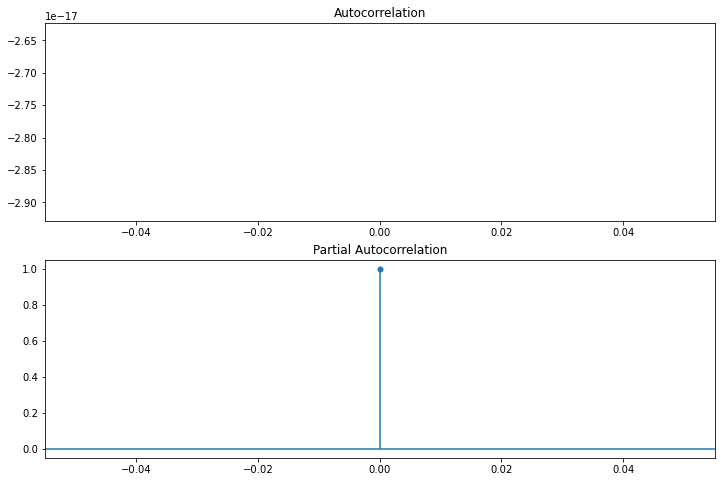

In [107]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df, lags=40, ax=ax2)

### Hyper-parameter Tuning : Finding out optimal (p,d,q)


In [108]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [109]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
# evaluate parameters
p_values = [0,1,2,3,4,5]
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, test.values, p_values, d_values, q_values)

## ARIMA

In [110]:
model_arima = ARIMA(train['CO2'],order = (3,1,4))
model_arima = model_arima.fit()
model_arima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  195
Model:                 ARIMA(3, 1, 4)   Log Likelihood                -156.502
Date:                Thu, 23 Dec 2021   AIC                            329.003
Time:                        23:51:12   BIC                            355.146
Sample:                    01-01-1800   HQIC                           339.589
                         - 01-01-1994                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4769      0.216      6.850      0.000       1.054       1.900
ar.L2         -0.1087      0.411     -0.265      0.791      -0.914       0.697
ar.L3         -0.4420      0.214     -2.068      0.039      -0.861      -0.023
ma.L1         -1.5512      0.225     -6.892      0.000      -1.992      -1.110
ma.L2          0.0678      0.410      0.165      0.869      -0.736       0.872
ma.L3          0.7709      0.210      3.667      0.000       0.359       1.183
ma.L4         -0.2141      0.057     -3.737      0.000      -0.326      -0.102
sigma2         0.2908      0.024     12.066      0.000       0.244       0.338
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                74.40
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):            3448.10   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

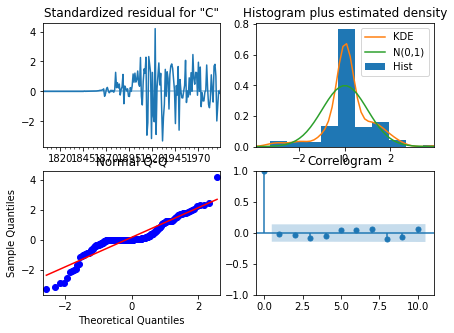

In [112]:
model_arima.plot_diagnostics(figsize=(7,5))
plt.show()

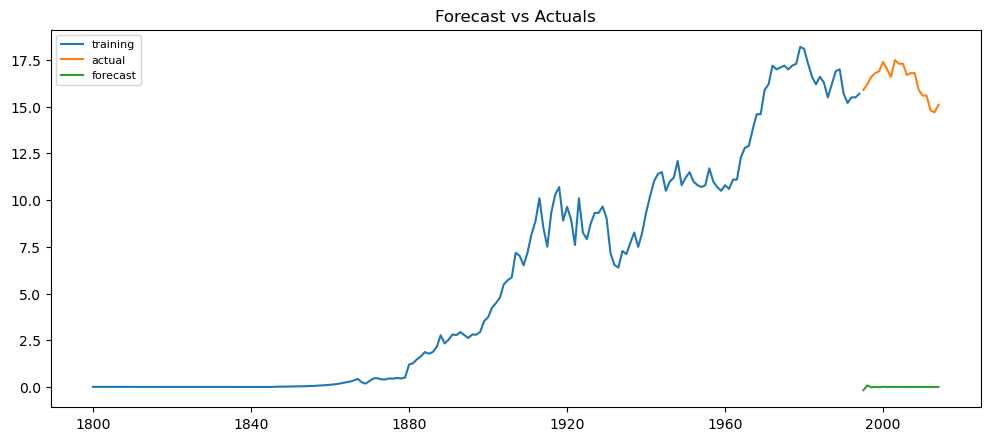

In [113]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_arima, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [114]:
ns_arima_acc = forecast_accuracy(pred_arima,test.CO2)
ns_arima_acc

{'mape': 1.000288523150746,
 'me': -16.379513993331827,
 'mae': 16.379513993331827,
 'mpe': -1.000288523150746,
 'rmse': 16.400772560198785}

## Auto ARIMA

In [115]:
model_auto = pm.auto_arima(train['CO2'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=327.249, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=328.890, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=328.788, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=329.304, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=330.241, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.304 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  195
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -161.625
Date:                Thu, 23 Dec 2021   AIC                            327.249
Time:                        23:51:17   BIC                            333.785
Sample:                             0   HQIC                           329.896
                                - 195                                         
Co

In [116]:
pred_auto_arima = model_auto.predict(start=start,end=end)
print(pred_auto_arima)

[15.78089841 15.86179682 15.94269523 16.02359364 16.10449205 16.18539046
 16.26628887 16.34718728 16.42808569 16.50898411]


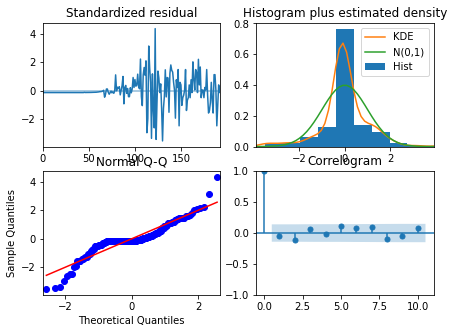

In [117]:
model_auto.plot_diagnostics(figsize=(7,5))
plt.show()

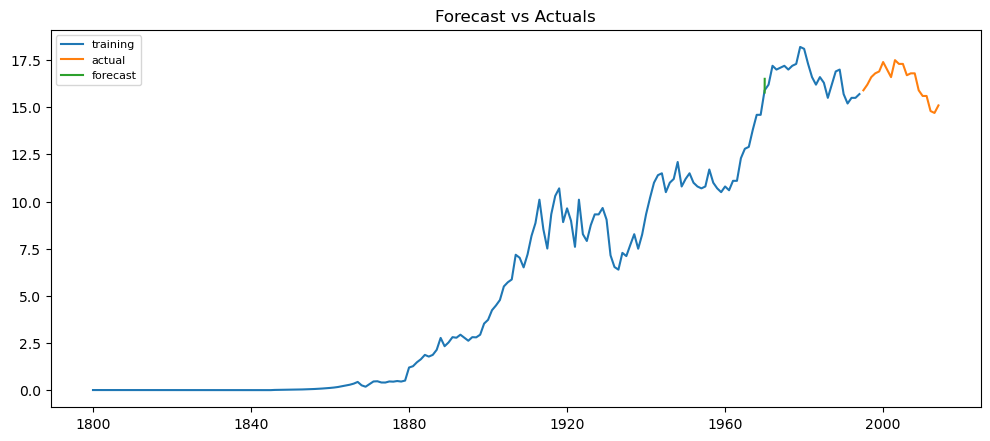

In [118]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_auto_arima, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Auto Regressor 

In [119]:
model_ar = AutoReg(train,lags = 1).fit()
print(model_ar.summary())

                            AutoReg Model Results                             
Dep. Variable:                    CO2   No. Observations:                  195
Model:                     AutoReg(1)   Log Likelihood                -161.622
Method:               Conditional MLE   S.D. of innovations              0.557
Date:                Thu, 23 Dec 2021   AIC                             -1.141
Time:                        23:51:21   BIC                             -1.090
Sample:                    01-01-1801   HQIC                            -1.120
                         - 01-01-1994                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0784      0.055      1.420      0.156      -0.030       0.187
CO2.L1         1.0004      0.007    149.772      0.000       0.987       1.014
                                    Roots           

In [121]:
ns_ar_acc = forecast_accuracy(pred_ar.values, test.values)
ns_ar_acc

{'mape': nan, 'me': nan, 'mae': nan, 'mpe': nan, 'rmse': nan}

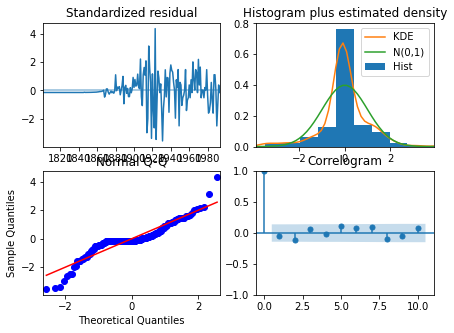

In [122]:
model_ar.plot_diagnostics(figsize=(7,5))
plt.show()

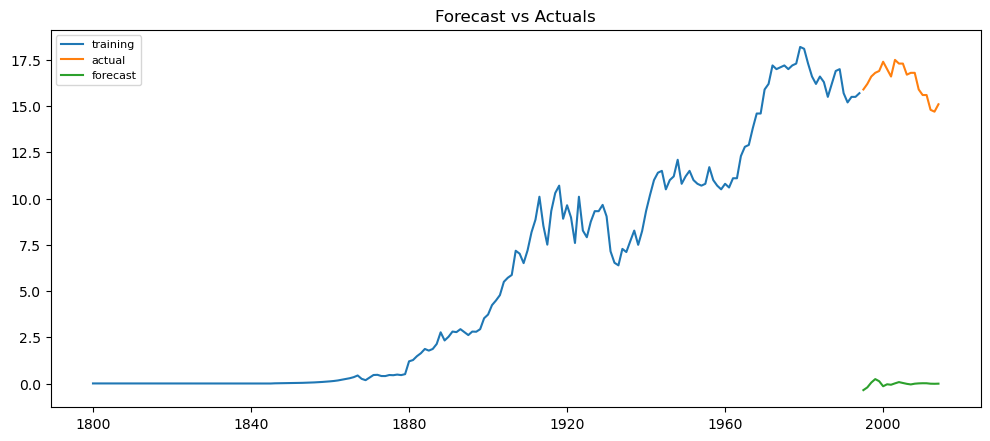

In [123]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ar, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Single Exponential Smoothing

In [124]:
fit1 = SimpleExpSmoothing(train).fit(smoothing_level = 0.2,optimized = False)
fit2 =SimpleExpSmoothing(train).fit(smoothing_level = 0.8,optimized = False)

Text(0.5, 1.0, 'Fitted values Vs Original Values')

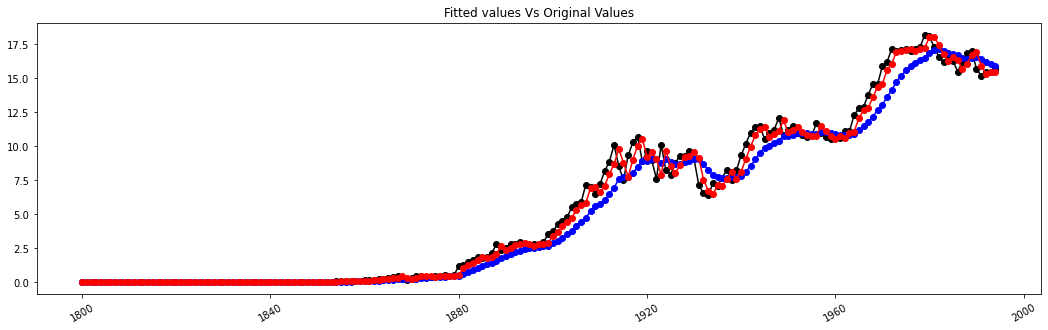

In [125]:
plt.figure(figsize=(18,5))
plt.plot(train,marker = 'o',color = 'black')
plt.xticks(rotation=30)
plt.plot(fit1.fittedvalues,marker = 'o',color = 'blue')
plt.plot(fit2.fittedvalues,marker = 'o',color = 'red')
plt.title('Fitted values Vs Original Values')

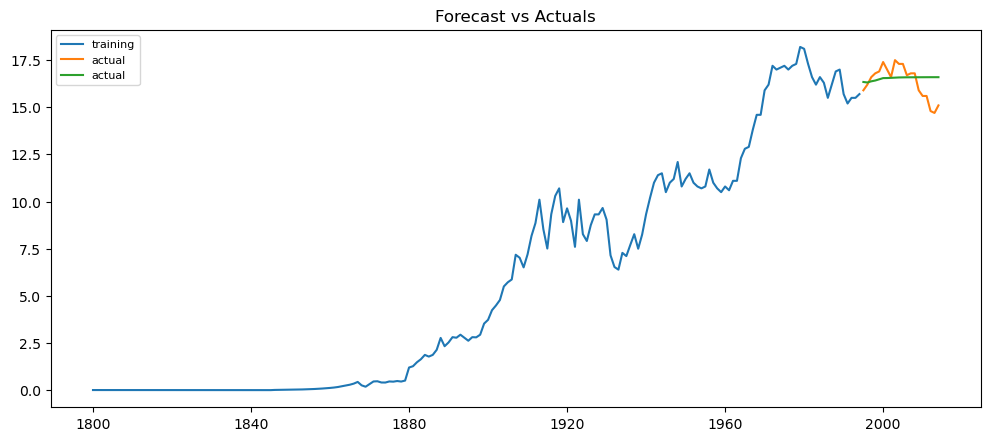

In [184]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
#plt.plot(pred_ses, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Double Exponential Smoothing or Holt's method

In [129]:
#fit1 = Holt(train1).fit()
fit3 = Holt(train,exponential=True,damped_trend=False).fit()

Text(0.5, 1.0, 'Fitted values Vs Original Values')

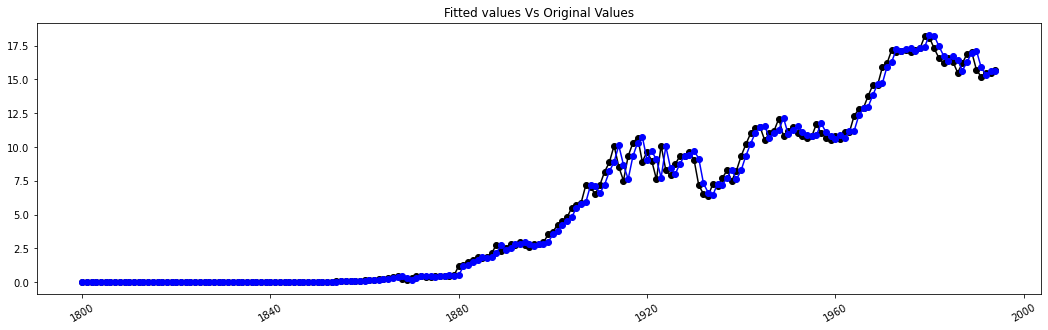

In [130]:
plt.figure(figsize=(18,5))
plt.plot(train,marker = 'o',color = 'black')
plt.xticks(rotation=30)
plt.plot(fit3.fittedvalues,marker = 'o',color = 'blue')
#plt.plot(fit2.fittedvalues,marker = 'o',color = 'red')
plt.title('Fitted values Vs Original Values')

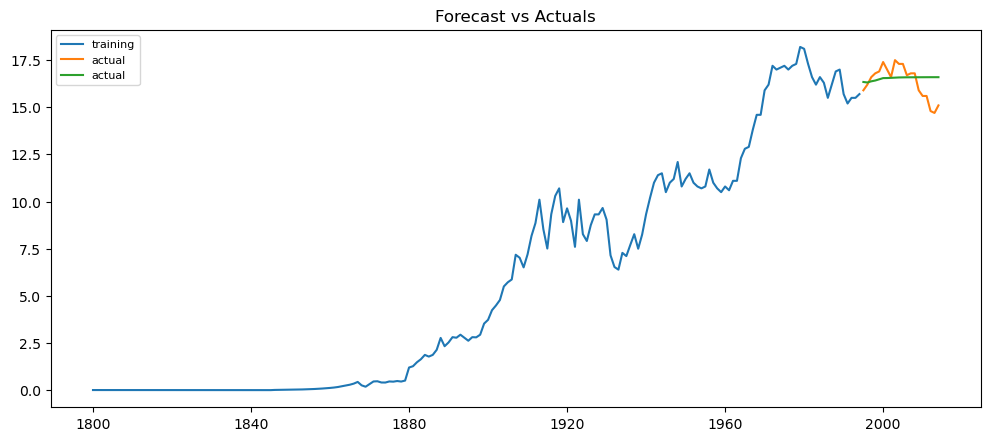

In [185]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
#plt.plot(pred_holt, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

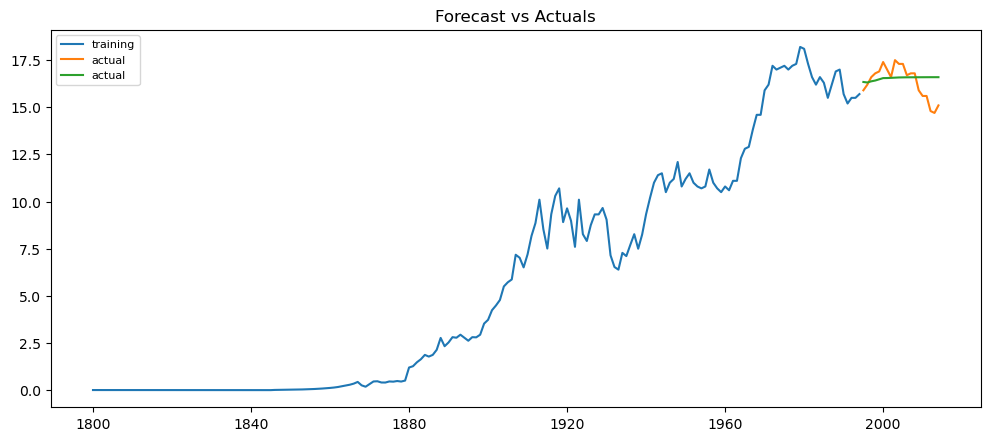

In [186]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
#plt.plot(pred_hwe_add_add, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

**seasonality = multiplicative** , **Trend = additive**

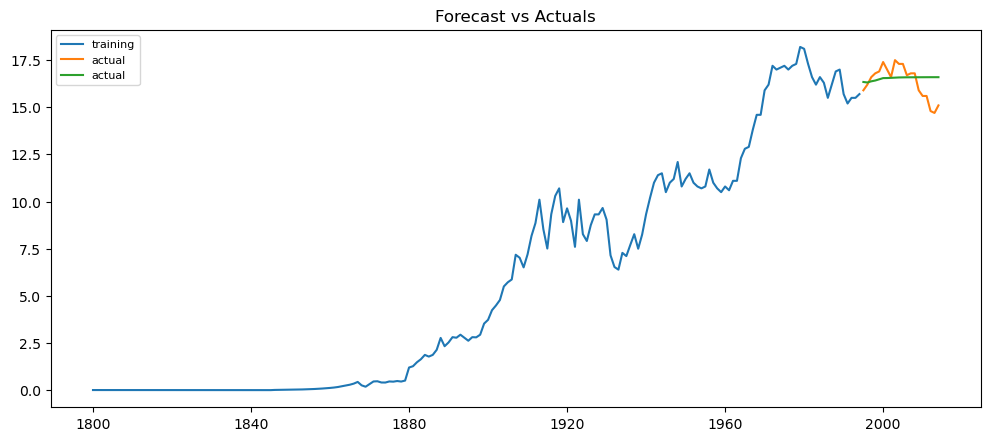

In [187]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
#plt.plot(pred_hwe_mul_add, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

**seasonality = multiplicative , Trend = multiplicative**

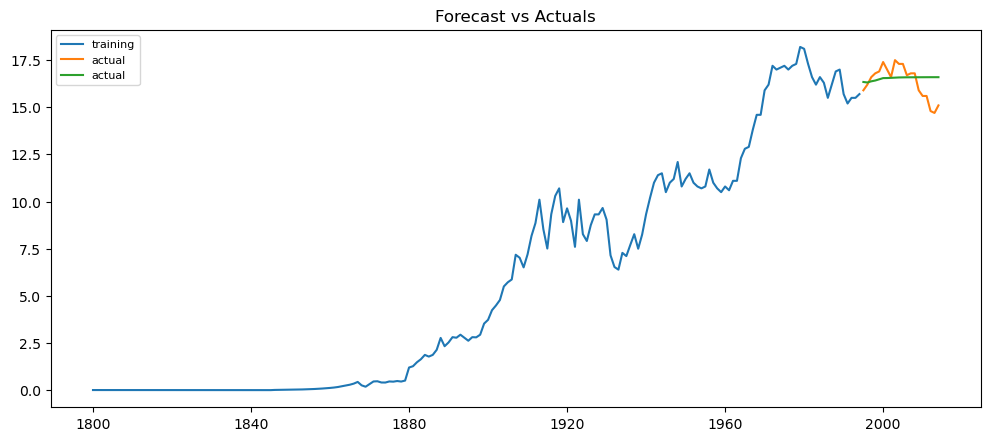

In [189]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
#plt.plot(pred_hwe_mul_mul, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## LSTM using RNN

In [143]:
scaler = MinMaxScaler()

In [144]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [145]:
scaled_train[:10]

array([[0.00021595],
       [0.00021211],
       [0.00020881],
       [0.00020496],
       [0.00020167],
       [0.00019837],
       [0.00019452],
       [0.00019123],
       [0.00018793],
       [0.00018463]])

In [146]:
#define generator
n_input = 5
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [147]:
X,y = generator[0]
print(f'given the array: \n{X.flatten()}')
print(f'predict this y: \n {y}')

given the array: 
[0.00021595 0.00021211 0.00020881 0.00020496 0.00020167]
predict this y: 
 [[0.00019837]]


In [148]:
X.shape

(1, 5, 1)

In [149]:
#define model
model = Sequential()
model.add(LSTM(60, activation = 'relu',return_sequences = True, input_shape=(n_input,n_features)))
model.add(Dropout(0.2))

model.add(LSTM(60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(60, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.compile(optimizer='adam',loss='mean_squared_error')

In [150]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 60)             14880     
_________________________________________________________________
dropout (Dropout)            (None, 5, 60)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 60)             29040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 60)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 60)             29040     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 60)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60)                2

In [151]:
#fit model
model.fit(generator,epochs=50,batch_size=32,verbose=1)

Epoch 1/50
190/190 [==============================] - 6s 7ms/step - loss: 0.1079
Epoch 2/50
190/190 [==============================] - 1s 7ms/step - loss: 0.0127
Epoch 3/50
190/190 [==============================] - 1s 7ms/step - loss: 0.0116
Epoch 4/50
190/190 [==============================] - 1s 7ms/step - loss: 0.0077
Epoch 5/50
190/190 [==============================] - 1s 7ms/step - loss: 0.0083
Epoch 6/50
190/190 [==============================] - 1s 7ms/step - loss: 0.0112
Epoch 7/50
190/190 [==============================] - 1s 7ms/step - loss: 0.0109
Epoch 8/50
190/190 [==============================] - 1s 7ms/step - loss: 0.0088
Epoch 9/50
190/190 [==============================] - 1s 7ms/step - loss: 0.0069
Epoch 10/50
190/190 [==============================] - 1s 7ms/step - loss: 0.0075
Epoch 11/50
190/190 [==============================] - 1s 7ms/step - loss: 0.0070
Epoch 12/50
190/190 [==============================] - 1s 7ms/step - loss: 0.0073
Epoch 13/50
190/190 [====

Text(0.5, 1.0, 'Loss per Epochs')

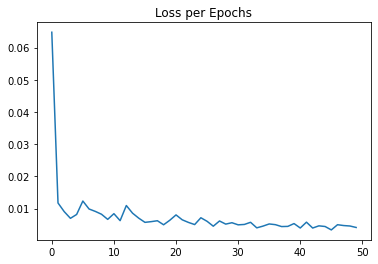

In [152]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.title('Loss per Epochs')

In [153]:
last_train_batch = scaled_train[-5:]

In [154]:
last_train_batch = last_train_batch.reshape(1,n_input,n_features)

In [155]:
model.predict(last_train_batch)

array([[0.89787585]], dtype=float32)

In [156]:
scaled_test[0]

array([0.87361422])

In [157]:
test_predictions =[]

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape(1,n_input,n_features)

for i in range(len(test)):
    
    #get the prediction value for first batch
    current_pred = model.predict(current_batch)[0]
    
    #append the prediction into the array
    test_predictions.append(current_pred)
    
    #use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis =1)

In [158]:
test_predictions

[array([0.89787585], dtype=float32),
 array([0.8963994], dtype=float32),
 array([0.8998196], dtype=float32),
 array([0.9021419], dtype=float32),
 array([0.9056832], dtype=float32),
 array([0.9091889], dtype=float32),
 array([0.90937716], dtype=float32),
 array([0.9100097], dtype=float32),
 array([0.9105487], dtype=float32),
 array([0.9110842], dtype=float32),
 array([0.9114346], dtype=float32),
 array([0.9115095], dtype=float32),
 array([0.911618], dtype=float32),
 array([0.9117078], dtype=float32),
 array([0.91177815], dtype=float32),
 array([0.91181767], dtype=float32),
 array([0.9118339], dtype=float32),
 array([0.91185117], dtype=float32),
 array([0.9118645], dtype=float32),
 array([0.9118736], dtype=float32),
 array([0.91187865], dtype=float32),
 array([0.9118816], dtype=float32),
 array([0.9118842], dtype=float32),
 array([0.9118861], dtype=float32),
 array([0.9118872], dtype=float32),
 array([0.911888], dtype=float32),
 array([0.91188836], dtype=float32),
 array([0.9118887], dty

In [159]:
test.head()

,CO2
Year,
1995-01-01,15.9
1996-01-01,16.2
1997-01-01,16.6
1998-01-01,16.8
1999-01-01,16.9


In [160]:
true_predictions = scaler.inverse_transform(test_predictions)

In [161]:
test['Predictions'] = true_predictions

<AxesSubplot:xlabel='Year'>

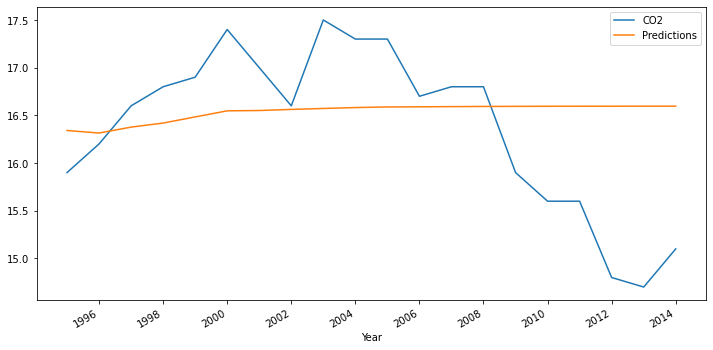

In [162]:
test.plot(figsize=(12,6))

In [163]:
ns_lstm_acc = forecast_accuracy(test['Predictions'],test.CO2)
ns_lstm_acc

{'mape': 0.04304935465787106,
 'me': 0.15933010141998372,
 'mae': 0.6836339055791505,
 'mpe': 0.012506182065013045,
 'rmse': 0.8663387023802581}

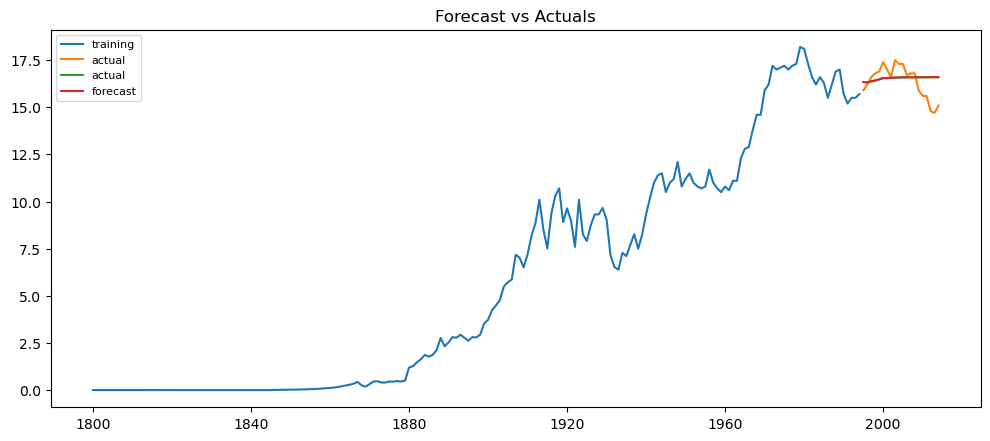

In [164]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(test['Predictions'], label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Final Model

We have selected **ARIMA(3,1,4)** as our final model beacuse of following reasons:
- least MAPE & MAE value
- Forecasted values vs Actual values graphs capturing more information when compared to other models

In [166]:
final_arima = ARIMA(df['CO2'],order = (3,1,4))
final_arima = final_arima.fit()
final_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  999
Model:                 ARIMA(3, 1, 4)   Log Likelihood                -167.000
Date:                Thu, 23 Dec 2021   AIC                            349.999
Time:                        23:54:02   BIC                            389.245
Sample:                             0   HQIC                           364.917
                                - 999                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4933      0.189      7.911      0.000       1.123       1.863
ar.L2         -0.1345      0.363     -0.371      0.711      -0.845       0.576
ar.L3         -0.4326      0.188     -2.296      0.022      -0.802      -0.063
ma.L1         -1.5757      0.196     -8.051      0.000      -1.959      -1.192
ma.L2          0.0977      0.362      0.270      0.787      -0.611       0.806
ma.L3          0.7822      0.188      4.150      0.000       0.413       1.152
ma.L4         -0.2332      0.051     -4.534      0.000      -0.334      -0.132
sigma2         0.2752      0.021     13.205      0.000       0.234       0.316
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             23690.62
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [167]:
final_arima.fittedvalues.tail()

Year
NaT    15.635926
NaT    15.636370
NaT    15.636874
NaT    15.637412
NaT    15.637955
dtype: float64

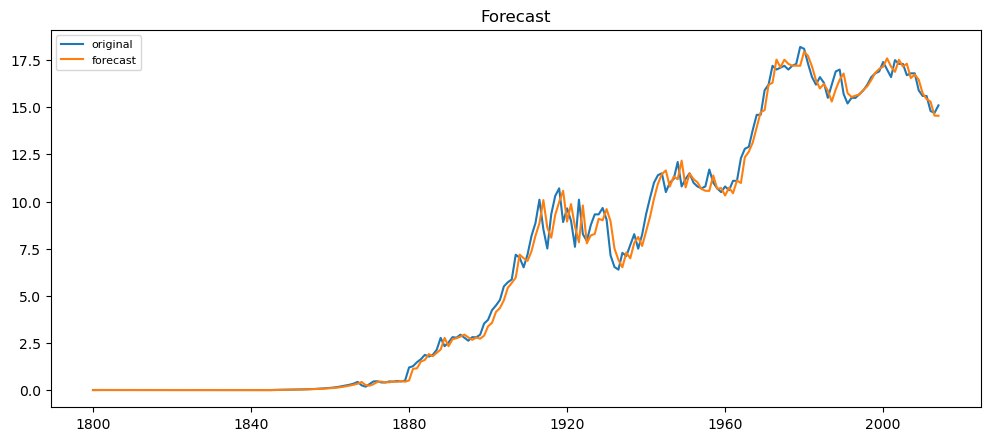

In [168]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(final_arima.fittedvalues, label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### creating dataframe for future forecasting

In [169]:
future_dates=[df.index[-1]+ DateOffset(years=x)for x in range(0,6)]

In [170]:
future_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [171]:
future_df.tail()

,CO2
NaT,NaN
NaT,NaN
NaT,NaN
NaT,NaN
NaT,NaN


In [172]:
len(future_df)

5

### Forecasting for  next 5 years using Final ARIMA model

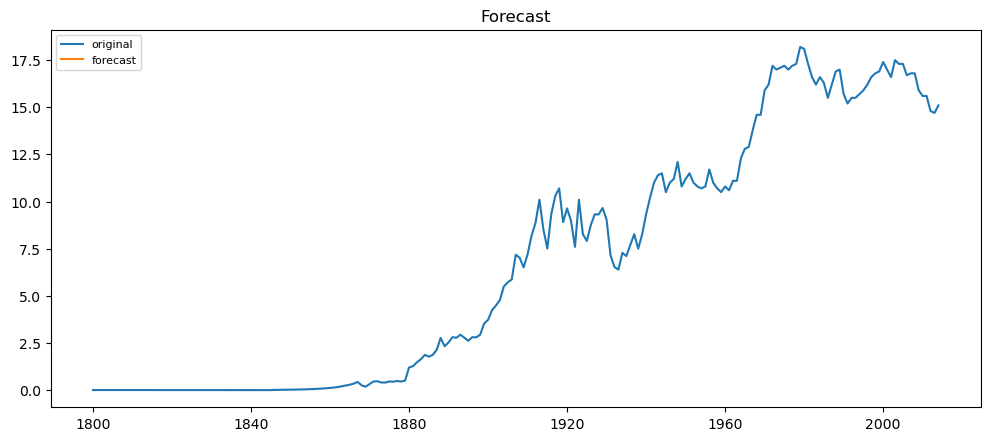

In [174]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(future_df['CO2'], label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [175]:
df.tail()

,CO2
Year,
NaT,NaN
NaT,NaN
NaT,NaN
NaT,NaN
NaT,NaN


In [176]:
future_df.tail()

,CO2
NaT,NaN
NaT,NaN
NaT,NaN
NaT,NaN
NaT,NaN


In [177]:
# Exporting to csv file
future_df.to_csv(r'forecast_data_5years.csv',index=True)

## Forecast for 10 years

In [178]:
future_dates_10=[df.index[-1]+ DateOffset(years=x)for x in range(0,11)]
future_df_10=pd.DataFrame(index=future_dates_10[1:],columns=df.columns)
future_df_10.tail()
len(future_df_10)

10

In [ ]:
future_df_10['CO2'] = final_arima.predict(start = 215, end = 225, dynamic= True) 

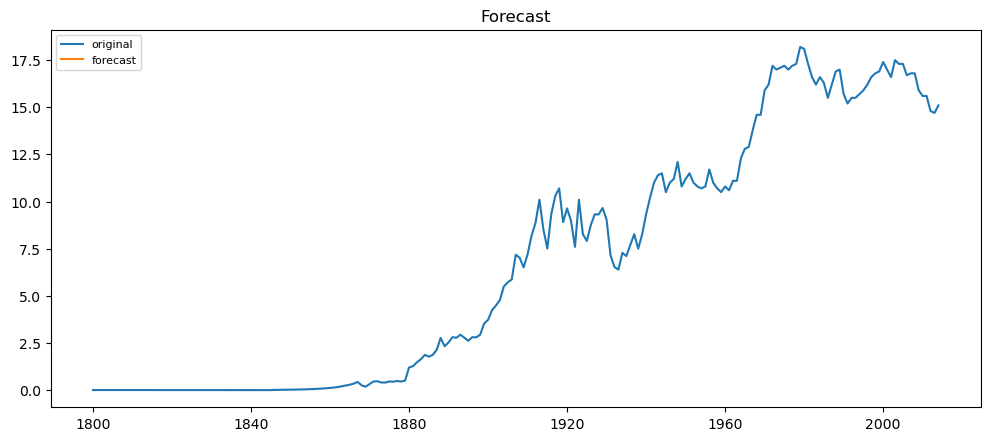

In [180]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(future_df_10['CO2'], label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [181]:
future_df_10

,CO2
NaT,NaN
NaT,NaN
NaT,NaN
NaT,NaN
NaT,NaN
NaT,NaN
NaT,NaN
NaT,NaN
NaT,NaN
NaT,NaN


In [182]:
# Exporting to csv file
future_df_10.to_csv(r'forecast_data_10years.csv',index=True)

In [183]:
# Saving the pickle file
import pickle
pickle.dump(final_arima, open('Forecast_arima.pkl','wb'))